# Introduction to data analysis for natural and social sciences
The present notebook contitutes the first part of the exam. Portions of data analysis and simulations present in article "Patient-specific Boolean models of signalling networks guide personalised treatments" are reproduced.

Notebook content is based on version 2 of the article, published April 18, 2022 (DOI: https://doi.org/10.7554/eLife.72626).

## Imports and global settings
Softwares bioLQM, GINsim and MaBoSS are used in the notebook to perform operations on the Boolean model. They are accessed through their respective Python interfaces.

In [57]:
import os.path

import biolqm
import ginsim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

PATH_REPORT = "report"
PATH_OUT = '.'

EXT_TAB = "tsv"

# Prostate Boolean model construction
The prostate Boolean model is built starting from information available in existing literature. A generic cancer Boolean network is used as baseline and contains information on pathways and interactions between nodes of the underlying signalling network which are commonly found in turmors.

Nodes of the network are biological entities involved in the regulation of the functions of the cell, e.g. genes, proteins, environmental conditions, transcription factors. Associated to nodes there are information such as logical rules governing the dynamics of the Boolean network and the pathway each node belongs to.

Edges represent interactions between the biological entities. They can be positive, when the activation of the source node results in the activation of the target node, or negative, when the activation of the source node inhibites the target node.

The initial model is enriched with prostate cancer-specific information. Software ROMA is used to identify new pathways from transcriptomics and proteomics data, by selecting highly variable genes for each pathway. Transcriptomics data is gathered from The Cancer Genome Atlas (TCGA) selecting gene sets pertained to cancer pathways. Database OmniPath is used to establish connections between genes present in the model and proteins known to have a function in prostate or found with ROMA.

The final network consists of 133 nodes and 449 edges. It is then translated to a Boolean model by identifying input nodes, which represent physiological conditions of the cell, and output nodes, which represent phenotypes of normal cell processes or cancer development.

## Data exploration
In this section, some operations are performed on the network data to develop a better understanding about their organisation and meaning.

The authors collected all data in the following Excel files. Data are loaded in Pandas dataframes to make their manipulation easier. Dataframe `df_nodes_pathways` relates pathways to nodes, dataframe `df_nodes_interactions` contains information about edges and nodes, e.g. logical rules, references to literature, interaction types, and dataframe `df_nodes_unique` lists additional information about nodes.

In [58]:
fname_nodes_pathways = "Montagud2022_nodes in pathways.xlsx"
fname_nodes_network = "Montagud2022_interactions_sources.xlsx"

df_nodes_pathways = pd.read_excel(
    io=os.path.join(PATH_REPORT, fname_nodes_pathways),
    header=None,
    names=["node", "pathway"]
)
print("Dataframe df_nodes_pathways")
df_nodes_pathways.info(verbose=True, memory_usage=False)

sheet_interactions = "Nodes"
df_nodes_interactions = pd.read_excel(
    io=os.path.join(PATH_REPORT, fname_nodes_network),
    sheet_name=sheet_interactions,
    header=1,
    converters={"Reference: PMID": lambda c: np.str_(c).strip()}  # Remove useless line breaks in cells.
)
print("\n\nDataframe df_nodes_interactions")
df_nodes_interactions.info(verbose=True, memory_usage=False)

sheet_unique="Nodes_unique"
df_nodes_unique = pd.read_excel(
    io=os.path.join(PATH_REPORT, fname_nodes_network),
    sheet_name=sheet_unique
)
print("\n\nDataframe df_nodes_unique")
df_nodes_unique.info(verbose=True, memory_usage=False)

Dataframe df_nodes_pathways
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   node     133 non-null    object
 1   pathway  133 non-null    object
dtypes: object(2)

Dataframe df_nodes_interactions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Target node       462 non-null    object
 1   HUGO names        454 non-null    object
 2   Interaction type  462 non-null    object
 3   Source            462 non-null    object
 4   Description       462 non-null    object
 5   Reference: PMID   453 non-null    object
 6   Logical rule      462 non-null    object
dtypes: object(7)

Dataframe df_nodes_unique
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 4 columns):
 #

### Check consistency
A single logical rule is associated to each node. Accordingly, the result of grouping interaction data by node and logical rule is a list of 133 rows.

Moreover, the number of edges can be obtained by counting pairs of source node and target node, excluding input nodes as targets.

In [59]:
display(df_nodes_interactions.groupby(["Target node", "Logical rule"]).count())

df_edge_no_inputs = df_nodes_interactions.loc[df_nodes_interactions["Source"] != "0/1"]
display(df_edge_no_inputs.groupby(["Target node", "Source"]).count())
del df_edge_no_inputs

,,HUGO names,Interaction type,Source,Description,Reference: PMID
Target node,Logical rule,,,,,
AKT,((HSPs | (PDK1 & PIP3) | PIP3 | (SHH & PIP3)) & !PTCH1),5,5,5,5,5
AMPK,(ATR | HIF1 | AMP_ATP | ATM) & !FGFR3,6,6,6,6,6
AMP_ATP,(!Nutrients),1,1,1,1,1
APAF1,((Caspase8 | BAX | p53 | Bak | HSPs) & !Bcl_XL & !BCL2 & !AKT),8,8,8,8,8
AR,((GLI | EP300 | HSPs | NKX3_1 | EZH2 | NCOA3 | PKC | SMAD | Androgen) & !PTEN & !NCOR1 & !NCOR2 & !MDM2),13,13,13,13,13
...,...,...,...,...,...,...
p21,((p53 | SMAD | HIF1 | ZBTB17) & !TERT & !MYC_MAX & !MDM2 & !AKT & !ERK),9,9,9,9,9
p38,(MAP3K1_3 & !ERK & !GADD45),3,3,3,3,3
p53,((Acidosis | CHK1_2 | p38 | HIF1) & !BCL2 & !MDM2 & !HSPs & !Snail),9,9,9,9,9


HUGO names  Interaction type  Description  \
Target node Source                                              
AKT         HSPs             1                 1            1   
            PDK1             1                 1            1   
            PIP3             1                 1            1   
            PTCH1            1                 1            1   
            SHH              1                 1            1   
...                        ...               ...          ...   
p53         p38              1                 1            1   
p70S6kab    PDK1             1                 1            1   
            mTORC2           1                 1            1   
p90RSK      ERK              1                 1            1   
            PDK1             1                 1            1   

                    Reference: PMID  Logical rule  
Target node Source                                 
AKT         HSPs                  1             1  
            PDK1                  1             1  
            PIP3                  1             1  
            PTCH1                 1             1  
            SHH                   1             1  
...                             ...           ...  
p53         p38                   1             1  
p70S6kab    PDK1                  1             1  
            mTORC2                1             1  
p90RSK      ERK                   1             1  
            PDK1                  1             1  

[449 rows x 5 columns]

In [60]:
# MC debug, remove in v0.2.0
# df_nodes_unique contains only 121 nodes and not 133 as df_nodes_pathways.
# In other words, df_nodes_unique["Node"] should be a subset of df_nodes_pathways["node"].
# Why is that? Let's find out.

df = df_nodes_pathways.set_index("node")
df_subset = df_nodes_unique.set_index("Node")

# The input nodes should be all removed since they are not regulated (by authors' design),
# hence they are not part of any pathway. But this is not what happens.
display(df.loc[df["pathway"] == "Input"])
display(df.drop(labels=df_subset.index, errors="ignore"))

# Moreover, in df_nodes_unique there is a node called MAX which is not part of the nodes considered for the final network.
# Surprisingly, it is not present among the nodes in df_nodes_interactions.
try:
    df.drop(labels=df_subset.index)
except Exception as e:
    print(e)
finally:
    del df
    del df_subset

# In conclusion, it seems that the choice of nodes from the Excel files can not be deduced directly
# just from the observation of the content of the files.
# In particular, I should use data in df_nodes_unique with caution,
# since their relation with the other data is not straightforward.

,pathway
node,
Acidosis,Input
Androgen,Input
Carcinogen,Input
EGF,Input
FGF,Input
fused_event,Input
Hypoxia,Input
Nutrients,Input
SPOP,Input


,pathway
node,
Acidosis,Input
Androgen,Input
Apoptosis,Output
Carcinogen,Input
DNA_Damage,DNA repair pathw
DNA_Repair,Output
EMT,Invasion pathw
Hypoxia,Input
Invasion,Output


"['MAX'] not found in axis"


### Data export
Data about nodes are exported in files with tab-separated values (TSV) format. Exported data can be imported in software Cytoscape for later use.

In [61]:
name_nodes_pathways = os.path.splitext(fname_nodes_pathways)[0]
name_nodes_network = os.path.splitext(fname_nodes_network)[0]

df_nodes_pathways.to_csv(
    path_or_buf=os.path.join(PATH_OUT, f"{name_nodes_pathways}.{EXT_TAB}"),
    sep='\t',
    index=False
)
df_nodes_interactions.to_csv(
    path_or_buf=os.path.join(PATH_OUT, f"{name_nodes_network}_{sheet_interactions}.{EXT_TAB}"),
    sep='\t',
    index=False
)
df_nodes_unique.to_csv(
    path_or_buf=os.path.join(PATH_OUT, f"{name_nodes_network}_{sheet_unique}.{EXT_TAB}"),
    sep='\t',
    index=False
)

Mandatory data to recreate the network are: source nodes, target nodes, interaction types, logical rules and pathways. A single file with at least these data can be constructed.

A note on the use of this file in Cytoscape: node "0/1" should be hidden because it is generated by the software as source node for the input nodes.

In [62]:
df_cytoscape = df_nodes_interactions.join(
    other=df_nodes_pathways.set_index("node"),
    on="Target node"
)
df_cytoscape.to_csv(
    path_or_buf=f"cytoscape_data.{EXT_TAB}",
    sep='\t',
    index=False
)

To build the regulatory network, GINsim is used by the authors. The resulting network is exported as ZGINML file, available in the Supplementary file 1 under the name specified in variable `fname_model`. The ZGINML file is then imported in Cytoscape for visual improvement.

In [63]:
fname_model = "Montagud2022_Prostate_Cancer.zginml"

### Network visualisation with GINsim<a id="sec:network_visualisation_with_ginsim"></a>
The GINsim model can be used directly for some tasks and all the information are contained in the ZGINML file. For instance the whole network can be displayed.

In [64]:
ginsim_model = ginsim.load(os.path.join(PATH_REPORT, fname_model))

ginsim.show(ginsim_model)

### Comparison with reference network
Only nine nodes are referred as proper inputs in the article (cfr. Appendix 1.2.3 and subsection "Boolean model construction" in section "Materials and methods"). The remaining two are "fused_event" and "SPOP".

Node "fused_event" is present to consider the condition of fusion between gene promoter TMPRSS2 and transcription factor ERG and is added manually based on existing literature (cfr. Appendix 1.1.5 and subsection "Prior knowledge network construction" in section "Materials and methods").

Node "SPOP" is present to consider mutations of gene SPOP which are frequent in prostate cancer (cfr. Appendix 1.1.2).

The following are supplied data regarding each of these nodes.

In [65]:
display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "fused_event"])
display(df_nodes_interactions.loc[df_nodes_interactions["Source"] == "fused_event"])

display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "SPOP"])
display(df_nodes_interactions.loc[df_nodes_interactions["Source"] == "SPOP"])

,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
197,fused_event,TMPRSS2,input,0/1,TMPRSS2-Ets gene fusions were identified in pr...,"23264855, 20118910",(fused_event)
198,fused_event,SLC45A3,input,0/1,TMPRSS2 and SLC45A3 were the only 5' partner i...,20118910,(fused_event)
199,fused_event,NDRG1,input,0/1,ERG gene rearrangements and mechanism of rearr...,20118910,(fused_event)


,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
39,AR_ERG,ERG fused,+,fused_event,ERG can fuse with TMPRSS2 protein to form an o...,23264855,((AR & fused_event) | (AR & fused_event & !NKX...


,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
420,SPOP,SPOP,input,0/1,Input of the model,NaN,(SPOP)


,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
125,DAXX,DAXX,-,SPOP,Phosphorylation of Daxx by ATM upon DNA damage...,23405218,(!ATM & !ATR & !SPOP)
128,DNA_Damage,NaN,+,SPOP,"From Fumia et al, 2013",23922675,((Carcinogen | (Carcinogen & ROS)) & !SPOP)
203,GLI,"GLI1, GLI2",-,SPOP,Stabilization of speckle-type POZ protein (Spo...,24072710,((WNT | SMO) & !SPOP)
312,NCOA3,NCOA3,-,SPOP,Mutations in SPOP represent the most common po...,24239470,(!SPOP & p38)


### Variation from reference for interactions of node "SPOP"
Inspecting imported data, node "SPOP" turns out to be an inhibitor for only three of its four children nodes (i.e. negative interaction type), but in the reference network all four interactions are set as inhibiting, following the respective logical rules.

This difference can be seen comparing the nodes from the Excel files which have "SPOP" as source node and the plot of the network loaded from the ZGINML file, made for example with GINsim (cfr. notebook section [Network visualisation with GINsim](#sec:network_visualisation_with_ginsim)).

Logical rules show the correct behaviour.

In [66]:
# Change dataframe display settings to improve visualization.
pat_old = pd.get_option("display.max_colwidth")
pd.set_option("display.max_colwidth", None)

display(df_nodes_interactions.loc[
    df_nodes_interactions["Source"] == "SPOP",
    ("Target node", "Interaction type", "Description", "Logical rule")
])

# Restore previous dataframe display settings.
pd.set_option("display.max_colwidth", pat_old)
del pat_old

,Target node,Interaction type,Description,Logical rule
125,DAXX,-,Phosphorylation of Daxx by ATM upon DNA damage disrupts the Daxx-Mdm2 interaction and facilitates p53 activation.,(!ATM & !ATR & !SPOP)
128,DNA_Damage,+,"From Fumia et al, 2013",((Carcinogen | (Carcinogen & ROS)) & !SPOP)
203,GLI,-,Stabilization of speckle-type POZ protein (Spop) by Daz interacting protein 1 (Dzip1) is essential for Gli turnover and the proper output of Hedgehog signaling.,((WNT | SMO) & !SPOP)
312,NCOA3,-,"Mutations in SPOP represent the most common point mutations in primary prostate cancer,with recurrent mutations in SPOP in 6% to 15% of multiple independent cohorts. Wild-type SPOP will bind and promote the degradation of SRC-3,whereas prostate cancer–derived SPOP mutants lose this ability,leading to increased androgen signaling in certain model systems.",(!SPOP & p38)


### Stable states evaluation with bioLQM
The stable states of the model can be found exactly. This task is performed by bioLQM.

In [67]:
biolqm_model = ginsim.to_biolqm(ginsim_model)
#biolqm_fixpoints = biolqm.fixpoints(biolqm_model)  # Comment out to speed up the execution of the notebook.

# Prostate Boolean model simulation
The time evolution of the Boolean network can be simulated using MaBoSS. For each simulation a State Transition Graph (STG) is built, which contains the states of the network as nodes and the possible transitions between states as edges. Initial conditions are set for each node as probabilities to be in an active state (i.e. value 1) or in an inactive state (i.e. value 0). Moreover the outputs of the simulation are set, which correspond to nodes for which the time evolution is tracked.

In this section, the Boolean model is used to retrace and discuss some simulations performed in the article. The Boolean model is imported from GINsim and configurations regarding the simulations are set, e.g. the number of stochastic trajectories to take into account for the averages.

In [68]:
maboss_model = ginsim.to_maboss(ginsim_model)

maboss_model.update_parameters(
    max_time=30,
    sample_count=5000
)

## Wild type simulation
The behaviour of an healthy prostate cell can be simulated under different physiological conditions. This model is called "wild type model" by the authors.

Simulations adopting the wild type model have the following initial conditions: inactive output nodes, active input nodes according to the physiological conditions under study and random state for the remaining nodes.

In the first wild type simulation, a prostate cell in a quiescent state is observed: no external or internal alterations are present. This translates into inactive initial state for all the input nodes of the network. The observed phenotypes are some of the output nodes, in particular "Apoptosis" and "Proliferation" which are not possible in a prostate cell in quiescent state.

In [69]:
maboss_wtA_model = maboss_model.copy()

for node in maboss_wtA_model.network:
    maboss_wtA_model.network.set_istate(node, [0.5, 0.5])

inactives_wtA = df_nodes_pathways.loc[
    (df_nodes_pathways["pathway"] == "Input") | (df_nodes_pathways["pathway"] == "Output")
]["node"].tolist()
for node in inactives_wtA:
    maboss_wtA_model.network.set_istate(node, [1, 0])

outputs_wtA = ["Apoptosis", "DNA_Repair", "Metastasis", "Proliferation"]
maboss_wtA_model.network.set_output(outputs_wtA)

The result of the simulation is a plot of time trajectories of probabilities for the given phenotypes. As expected, the selected phenotypes becomes quickly inactive as the simulation progresses since they correspond to abnormal behaviours (i.e. "Metastasis", "DNA_Repair") or to limiting cases of the cell life (i.e. "Apoptosis", "Proliferation").

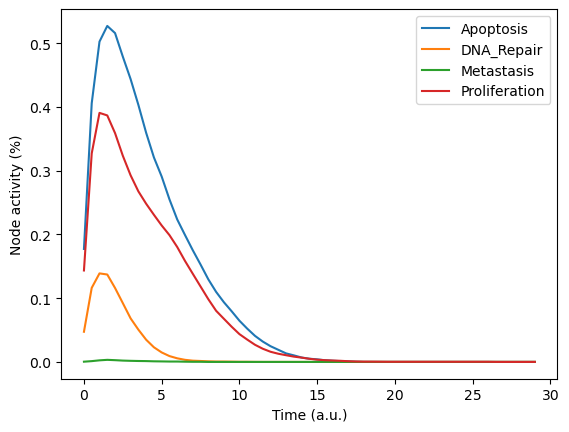

In [70]:
maboss_wtA_result = maboss_wtA_model.run()

maboss_wtA_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Node activity (%)"
)
plt.savefig(os.path.join(PATH_OUT, "3A.pdf"))

The second simulation reproduce the behaviour of a prostate cell with growth factors activated. Under physiological conditions this results in the activation of the cell cycle. Nodes active at the begginning are listed in variable `actives_wtB`, while node "SPOP" is set with random initial state. Phenotypes of the second simulation are listed in variable `outputs_wtB` and include some intermediate nodes other than a subset of the output nodes.

In [71]:
maboss_wtB_model = maboss_wtA_model.copy()

actives_wtB = ["EGF", "FGF", "Nutrients", "Androgen"]
for node in actives_wtB:
    maboss_wtB_model.network.set_istate(node, [0, 1])
maboss_wtB_model.network.set_istate("SPOP", [0.5, 0.5])

outputs_wtB = ["Apoptosis", "CyclinD", "E2F1", "Metastasis", "Proliferation", "p53"]
maboss_wtB_model.network.set_output(outputs_wtB)

The following is the trajectory plot of the second simulation. Protein Cyclin D is produced and corresponds to the growth of the cell, which ultimately results in the cell division (i.e. phenotype "Proliferation").

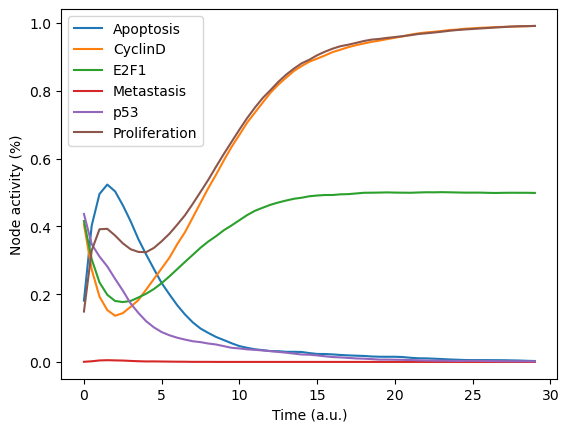

In [72]:
maboss_wtB_result = maboss_wtB_model.run()

maboss_wtB_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Node activity (%)"
)
plt.savefig(os.path.join(PATH_OUT, "3B.pdf"))

The third simulation explores the effects of the introduction of cell death factors. Active input nodes are lists in variable `actives_wtC` and the output nodes are the same of the second simulation.

In [73]:
maboss_wtC_model = maboss_wtA_model.copy()

actives_wtC = ["Carcinogen", "Androgen", "TNFalpha", "Acidosis", "Hypoxia"]
for node in actives_wtC:
    maboss_wtC_model.network.set_istate(node, [0, 1])

maboss_wtC_model.network.set_output(outputs_wtB)

The trajectory plot of the third simulation is the following, where under normal circumstances the damaged cell starts the processes that lead to apoptosis.

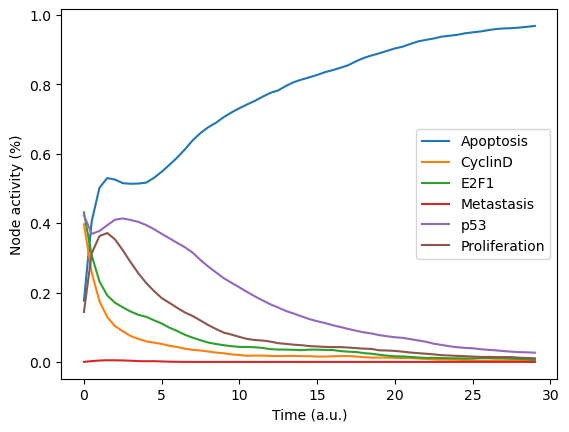

In [74]:
maboss_wtC_result = maboss_wtC_model.run()

maboss_wtC_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Node activity (%)"
)
plt.savefig(os.path.join(PATH_OUT, "3C.pdf"))

## Model validation
The model is validated by simulating some known interactions between genes in prostate cells under physiological conditions.

For example the order of events during cell cycle is tested. In this case the initial conditions are active growth factors and nutrients, together with nodes related to the activation of the cell cycle, while the cyclins start inactive. All the other nodes have random initial state. The outputs are list in variable `outputs_cellcycle`.

In [75]:
maboss_cellcycle_model = maboss_wtA_model.copy()

actives_cellcycle = ["EGF", "FGF", "Nutrients", "p21", "RB1"]
for node in actives_cellcycle:
    maboss_cellcycle_model.network.set_istate(node, [0, 1])

inactives_cellcycle = ["CyclinB", "CyclinD", "E2F1"]
for node in inactives_cellcycle:
    maboss_cellcycle_model.network.set_istate(node, [1, 0])

outputs_cellcycle = ["CyclinB", "CyclinD", "E2F1", "Proliferation"]
maboss_cellcycle_model.network.set_output(outputs_cellcycle)

Trajectories resulting from the simulation show the correct order of activation of cyclins.

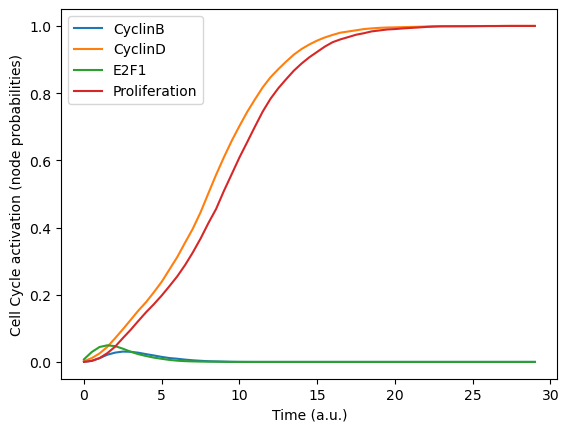

In [76]:
maboss_cellcycle_result = maboss_cellcycle_model.run()

maboss_cellcycle_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="Cell Cycle activation (node probabilities)"
)
plt.savefig(os.path.join(PATH_OUT, "5.pdf"))

## Mutants simulation
The Boolean model can be used to study effects of mutations which activate or inhibite some nodes, or in general which deviate their functioning from physiological conditions.

### Single mutations
One case is a loss-of-function mutation, i.e. permanent inactivation, of node "FOXA1". Initial conditions differs from the wild type model for the activation of growth factors and random initial state for node "SPOP". All the network output nodes are observed as phenotypes.

In [77]:
maboss_FOXA1_model = maboss_wtA_model.copy()

maboss_FOXA1_model.mutate("FOXA1", "OFF")

maboss_FOXA1_model.network.set_istate("EGF", [0,1])
maboss_FOXA1_model.network.set_istate("FGF", [0,1])
maboss_FOXA1_model.network.set_istate("Nutrients", [0,1])
maboss_FOXA1_model.network.set_istate("SPOP", [0.5,0.5])

outputs_network = df_nodes_pathways.loc[df_nodes_pathways["pathway"] == "Output"]["node"].tolist()
maboss_FOXA1_model.network.set_output(outputs_network)

The results of this simulation are

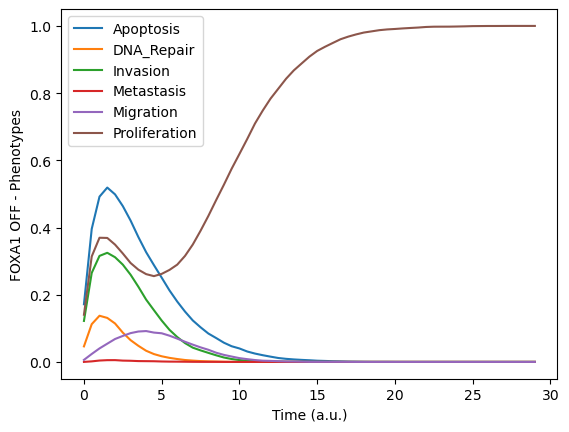

In [78]:
maboss_FOXA1_result = maboss_FOXA1_model.run()

maboss_FOXA1_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="FOXA1 OFF - Phenotypes"
)
plt.savefig(os.path.join(PATH_OUT, "6A.pdf"))

Another mutation affecting a single node is the inactivation of gene TP53, which inhibite node "p53". Phenotype "Caspase3" is added to the outputs of the previous simulation.

In [79]:
maboss_p53_model = maboss_wtA_model.copy()

maboss_p53_model.mutate("p53", "OFF")

outputs_p53 = outputs_network.copy()
outputs_p53.append("Caspase3")
maboss_p53_model.network.set_output(outputs_p53)

The result of the simulation is the following.

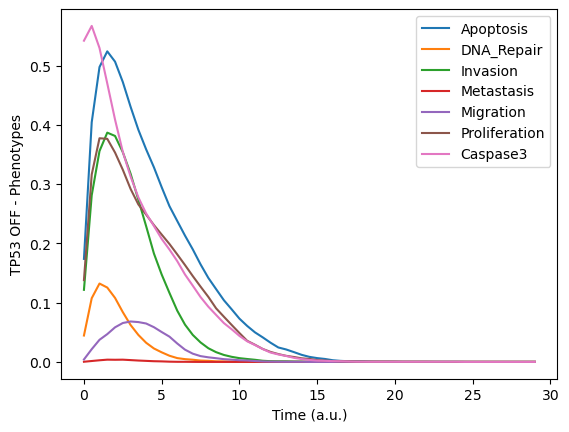

In [80]:
maboss_p53_result = maboss_p53_model.run()

maboss_p53_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="TP53 OFF - Phenotypes"
)
plt.savefig(os.path.join(PATH_OUT, "6B.pdf"))

### Multiple mutations
During cancer progression multiple mutations accumulate and their effects and interactions can be simulated.

An example is the interaction between gene fusion TMPRSS2:ERG and a loss-of-function mutation of gene NKX3_1. The starting model is the wild type model, with active nodes in list `actives_multiple` and random value for node "SPOP" as initial conditions. Outputs of the simulation are the output nodes of the network. The mutations are applied simultaneously.

In [81]:
maboss_multiple_model = maboss_wtA_model.copy()

actives_multiple = ["EGF", "FGF", "Nutrients", "Carcinogen"]
for node in actives_multiple:
    maboss_multiple_model.network.set_istate(node, [0, 1])
maboss_multiple_model.network.set_istate("SPOP", [0.5, 0.5])

maboss_multiple_model.network.set_output(outputs_network)

maboss_multiple_model.mutate("AR_ERG", "ON")
maboss_multiple_model.mutate("NKX3_1", "OFF")

The result of the simulation is the following. Contrary to the article result, this combination of mutations do not activate phenotype "Metastasis".

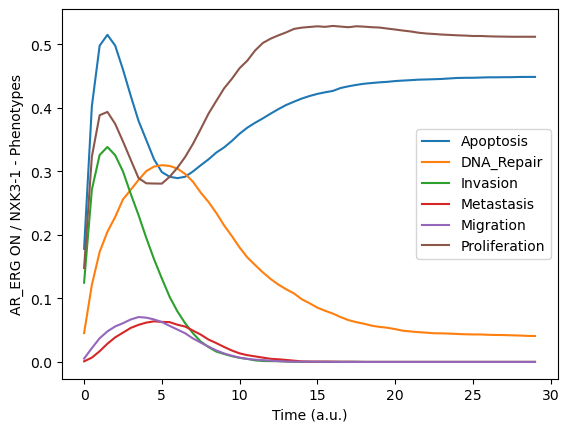

In [82]:
maboss_multiple_result = maboss_multiple_model.run()

maboss_multiple_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="AR_ERG ON / NXK3-1 - Phenotypes"
)
plt.savefig(os.path.join(PATH_OUT, "7.pdf"))

To investigate the reason for the difference with the article, first logical rule and interactions leading to node "Metastasis" are inspected: the logical rule is an AND condition between node "Migration" and "AR_ERG", with the latter always active due to the mutation.

In [83]:
display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "Metastasis"])

,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
276,Metastasis,output,+,AR_ERG,The overexpression of ERG is one of the key fa...,25915839,(Migration & AR_ERG)
277,Metastasis,output,+,ERG,The overexpression of ERG is one of the key fa...,25915839,(Migration & AR_ERG)
278,Metastasis,output,+,Migration,"From Cohen et al, 2015",26528548,(Migration & AR_ERG)


Consequently, data regarding target node "Migration" are inspected. Observing the previous simulation and taking into account the logical rule of the node, the source of the problem is the inactivation of node "Invasion" during the progression of the simulation. This is confirmed by comparing this plot with the respective figure in the article (cfr. Appendix 1 - figure 7).

In [84]:
display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "Migration"])

,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
279,Migration,output,+,AKT,"Overall, we have dissected signaling pathways ...",26207671,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
280,Migration,output,+,AR,"The present report, for the first time, indica...",21359179,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
281,Migration,output,+,EMT,"From Cohen et al, 2015",26528548,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
282,Migration,output,+,ERK,we provide evidence that propagation waves of ...,29112851,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
283,Migration,output,+,ETV1,ETV1 overexpressioni n human LNCaP prostate ca...,23076342,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)
284,Migration,output,+,Invasion,"From Cohen et al, 2015",26528548,(((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)


Logical rule of target node "Invasion" contains nodes all having random initial conditions. To test the effect of one of the nodes initially activated, node "beta_catenin" is chosen because observing the logical rule, its activation affects directly the initial condition of node "Invasion".

In [85]:
# Change dataframe display settings to improve visualization.
pat_old = pd.get_option("display.max_colwidth")
pd.set_option("display.max_colwidth", None)

display(df_nodes_interactions.loc[df_nodes_interactions["Target node"] == "Invasion"])


# Restore previous dataframe display settings.
pd.set_option("display.max_colwidth", pat_old)
del pat_old

maboss_multiple_model.network.set_istate("beta_catenin", [0, 1])

,Target node,HUGO names,Interaction type,Source,Description,Reference: PMID,Logical rule
244,Invasion,output,+,beta_catenin,Deletion of β-Catenin in a Pten deleted model of castration-resistant prostate cancer demonstrated it is dispensable for disease progression,23300485,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_catenin)
245,Invasion,output,+,CDH2,N-cadherin is required for TGFbeta induced invasion,15331629,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_catenin)
246,Invasion,output,+,EZH2,EZH2 regulates tumor invasion via the transcriptional repression of the metastasis suppressor RKIP in breast and prostate cancer.,22505648,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_catenin)
247,Invasion,output,+,SMAD,"TGF-b induces MMP-2 and MMP-9 expresion, using SMAD (among others)",22614218,((CDH2 & SMAD) | (CDH2 & SMAD & EZH2) | beta_catenin)


The resulting trajectories are similar to the previous simulation. The only  significant difference is the initial behaviour of phenotype "Invasion", which have greater probability to be active in the initial instants of the simulation, as direct consequence of the test.

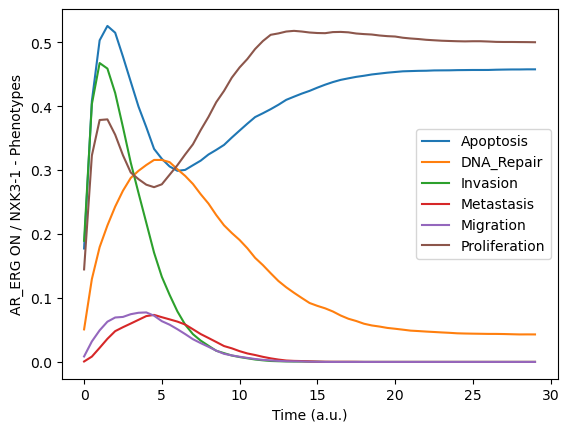

In [86]:
maboss_multiple_result = maboss_multiple_model.run()

maboss_multiple_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="AR_ERG ON / NXK3-1 - Phenotypes"
)
plt.savefig(os.path.join(PATH_OUT, "7_bis.pdf"))

The test can be reinforced by considering a gain-of-function mutation of node "beta_catenin".

In [87]:
maboss_multiple_model.mutate("beta_catenin", "ON")

The first consequence of this mutation is to activate in order nodes "Invasion", "Metastasis" and "Migration", as expected. However, this is not the behaviour observed in the article, since phenotype "Invasion" is activated directly and permanently. Hence there must be another interaction on node "Invasion" which leads to an overall activatory behaviour without truncating the influence of other inhibitory interactions. Further experiments with the nodes constituting the logical rule of node "Invasion" are required.

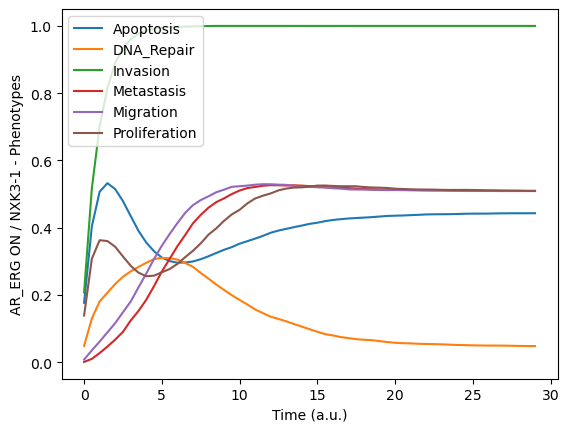

In [88]:
maboss_multiple_result = maboss_multiple_model.run()

maboss_multiple_result.get_nodes_probtraj().plot(
    legend=True,
    xlabel="Time (a.u.)",
    ylabel="AR_ERG ON / NXK3-1 - Phenotypes"
)
plt.savefig(os.path.join(PATH_OUT, "7_tris.pdf"))

# Personalisation of the prostate Boolean model
In this section a summary of the application of patient data to the prostate Boolean model is provided, with reference to the sections of the article where further details are available.

Authors use their PROFILE methodology to integrate TCGA prostate cancer data of 488 patients into the wild type model. In particular mutation and Copy Number Alteration (CNA) data and continuous data from RNA sequencing are analysed to insert variations specific to each patient into the Boolean model. Depending on the data type, the effects are different: the value of a node affected by mutation or CNA is set permanently to 0 or 1 depending on the effect of the alteration, while expression data are converted to specific transition rates and initial conditions. The biological interpretation of these rules is the permanent alteration of node states if genetic mutations are present and in the variation of the signal propagated between nodes due to the regulation of gene expression. Logical rules are not affected by any change.

Additional details on the procedure are explained in Appendix 3, Appendix 4.1, subsection "Personalisation of the prostate Boolean model" in Section "Results" and subsection "Data tailoring the Boolean model" in Section "Materials and methods".

## Personalised drug predictions of TCGA Boolean models
The 488 personalised prostate Boolean models are used to get insights on possible drug treatments. Authors study which genes, when inhibited, cause inhibition of phenotype "Proliferation" or activation of phenotype "Apoptosis". Furthermore, this search is extended to comprehend combinations of treatments.

Identify these particular genes in each patient translates to the possibility of creating personalised treatments, where the outcomes of the drug effects on the regulatory network of each patient are simulated with their respective prostate Boolean model.

Additional details on the results of the analysis are presented in Appendix 4.2, subsection "Personalised drug predictions of TCGA Boolean models" in Section "Results" and subsection "Data tailoring the Boolean model" in Section "Materials and methods".

## Personalised drug predictions of LNCaP Boolean model and experimental validations
To investigate the validity of the predictions of the personalised prostate Boolean models, drug assays are performed on selected cell lines. In particular, cell line LNCaP is chosen for comparison between in silico simulations and in vitro drug perturbation experiments.

Since these topics are not part of the course, only references to the article sections are provided: Appendices from 5 to 8, subsections "Personalised drug predictions of LNCaP Boolean model", "Experimental validation of predicted targets", "Experimental validation of drugs in LNCaP" in Section "Results" and subsections from "High-throughput mutant analysis of Boolean models" to "Real-time cell electronic sensing (RT-CES) cytotoxicity assay" in Section "Materials and methods".